# Import

In [170]:
import numpy as np
import healpy as hp
import pandas as pd
import networkx as nx
import geopandas as gpd

from pint import UnitRegistry
from tqdm.auto import tqdm
from itertools import combinations

from pyproj import Geod
from shapely import union_all, intersects
from shapely.wkt import loads
from shapely.geometry import LineString
from healpix_geo.nested import healpix_to_lonlat
from healpix_geo.nested import lonlat_to_healpix

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt

ureg = UnitRegistry()

In [2]:
def get_points(NSIDE):
    NPIX = hp.nside2npix(NSIDE)
    points = np.array(
        hp.pix2vec(NSIDE, range(NPIX), nest=True)
    ).T

    df = pd.DataFrame(points, columns=('x', 'y', 'z'))

    return df

def get_patches(NSIDE):
    NPIX = hp.nside2npix(NSIDE)

    pixels = np.arange(NPIX)
    patches = np.array(
        [hp.boundaries(NSIDE, i, nest=True).T for i in pixels]
    ).reshape(-1, 3)

    df = pd.DataFrame(patches, columns=('x', 'y', 'z'))

    return df

In [3]:
def great_circle_path(a=None, b=None, n_points=100, iterable=False):
    geod = Geod(ellps='WGS84')

    if iterable:
        (a, b) = a

    points = geod.npts(
        a.x, a.y,
        b.x, b.y,
        n_points,
    )
    line = LineString(points)

    return line

def great_circle_distance(a=None, b=None, iterable=False):
    geod = Geod(ellps='WGS84')

    if iterable:
        (a, b) = a

    distance = geod.inv(
        a.x, a.y,
        b.x, b.y,
    )[2]

    return distance

# Data

## Borders

In [4]:
kaz = gpd.read_file('data/geoBoundaries-KAZ-ADM0_simplified.geojson')
ukr = gpd.read_file('data/geoBoundaries-UKR-ADM0_simplified.geojson')
rus = gpd.read_file('data/geoBoundaries-RUS-ADM0_simplified.geojson')
blr = gpd.read_file('data/geoBoundaries-BLR-ADM0_simplified.geojson')
borders = pd.concat((kaz, ukr, rus, blr)).reset_index(drop=True)
borders = borders.to_crs(epsg=4326)
borders

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Kazakhstan,KAZ,12445969B25401373275960,KAZ,ADM0,"MULTIPOLYGON (((50.3741 44.78639, 50.37386 44...."
1,Ukraine,UKR,60985579B58127766181095,UKR,ADM0,"POLYGON ((33.19618 52.37361, 33.19572 52.37895..."
2,Russian Federation,RUS,89588193B69022144921215,RUS,ADM0,"MULTIPOLYGON (((130.82214 42.4629, 130.8202 42..."
3,Belarus,BLR,10690812B6439167788480,BLR,ADM0,"POLYGON ((31.78388 52.10805, 31.78611 52.12416..."


## Airports

In [5]:
airports = pd.read_csv('data/airports.csv')
airports = gpd.GeoDataFrame(
    airports.drop(['GeoPointLat', 'GeoPointLong'], axis=1),
    geometry=gpd.points_from_xy(
        *airports[['GeoPointLong', 'GeoPointLat']].values.T
    ), crs='EPSG:4326'
)
airports[airports.ICAO.isin(['KJFK', 'UAAA'])]

,AirportName,IATA,ICAO,TimeZone,City_Name,City_IATA,UTC_Offset_Hours,UTC_Offset_Seconds,Country_CodeA2,Country_CodeA3,Country_Name,geometry
2169,John F Kennedy Intl,JFK,KJFK,America/New_York,"New York, New York",NYC,-4.0,-14400.0,US,USA,United States of America,POINT (-73.77892 40.63975)
5300,Almaty,ALA,UAAA,Asia/Qyzylorda,Almaty,ALA,5.0,18000.0,KZ,KAZ,Kazakhstan,POINT (77.04051 43.35207)


# HEALPix

In [6]:
NSIDE = 16
healpix = get_points(NSIDE)

NPIX = hp.nside2npix(NSIDE)
ipix = np.arange(NPIX)
depth = np.log2(NSIDE).astype(int)

print(NPIX, depth)

3072 4


In [7]:
lon, lat = healpix_to_lonlat(ipix, depth=depth, ellipsoid='WGS84')
lon = (lon + 180) % 360 - 180

In [8]:
gdf = gpd.GeoDataFrame(
    healpix,
    geometry=gpd.points_from_xy(
        lon, lat
    ),
    crs='EPSG:4326',
)
gdf

,x,y,z,geometry
0,0.706493,0.706493,0.041667,POINT (45 2.39873)
1,0.669223,0.738374,0.083333,POINT (47.8125 4.80155)
2,0.738374,0.669223,0.083333,POINT (42.1875 4.80155)
3,0.701561,0.701561,0.125000,POINT (45 7.21266)
4,0.629418,0.766948,0.125000,POINT (50.625 7.21266)
...,...,...,...,...
3067,0.629418,-0.766948,-0.125000,POINT (-50.625 -7.21266)
3068,0.701561,-0.701561,-0.125000,POINT (-45 -7.21266)
3069,0.738374,-0.669223,-0.083333,POINT (-42.1875 -4.80155)
3070,0.669223,-0.738374,-0.083333,POINT (-47.8125 -4.80155)


In [9]:
start = lonlat_to_healpix(
    airports[airports.ICAO=='UAAA'].geometry.x,
    airports[airports.ICAO=='UAAA'].geometry.y,
    depth,
    ellipsoid='WGS84',
)[0]
end = lonlat_to_healpix(
    airports[airports.ICAO=='KJFK'].geometry.x,
    airports[airports.ICAO=='KJFK'].geometry.y,
    depth,
    ellipsoid='WGS84',
)[0]

In [10]:
df = pd.read_csv('point_pairs_full.csv', index_col=False)
df = df[~df.intersect_avoid].reset_index()
df

,index,point_a,point_b,path,intersect_avoid,healpix_id_a,healpix_id_b,distance
0,0,POINT (45 2.3987250992841447),POINT (47.8125 4.801554594177967),LINESTRING (45.055020515638404 2.4459152101302...,False,0,1,4.101488e+05
1,1,POINT (45 2.3987250992841447),POINT (42.1875 4.801554594177967),LINESTRING (44.944979484361596 2.4459152101302...,False,0,2,4.101488e+05
2,2,POINT (45 2.3987250992841447),POINT (45 7.212658108949127),"LINESTRING (45 2.4931214185652424, 45 2.587517...",False,0,3,5.323378e+05
3,3,POINT (45 2.3987250992841447),POINT (50.625 7.212658108949127),LINESTRING (45.109656950531374 2.4934954503132...,False,0,4,8.200651e+05
4,4,POINT (45 2.3987250992841447),POINT (53.4375 9.636338620241146),LINESTRING (45.1637069675639 2.541664115293592...,False,0,5,1.229631e+06
...,...,...,...,...,...,...,...,...
3695545,4094086,POINT (-45 -7.212658108949127),POINT (-47.8125 -4.801554594177967),LINESTRING (-45.055400500283824 -7.16553202138...,False,3068,3070,4.099221e+05
3695546,4094087,POINT (-45 -7.212658108949127),POINT (-45 -2.3987250992841447),"LINESTRING (-45 -7.11827481121803, -45 -7.0238...",False,3068,3071,5.323378e+05
3695547,4094088,POINT (-42.1875 -4.801554594177967),POINT (-47.8125 -4.801554594177967),LINESTRING (-42.297792946608595 -4.80200065705...,False,3069,3070,6.239875e+05
3695548,4094089,POINT (-42.1875 -4.801554594177967),POINT (-45 -2.3987250992841447),LINESTRING (-42.24280404901021 -4.754534435995...,False,3069,3071,4.101488e+05


# Graph

In [11]:
G = nx.from_edgelist(
    df[['healpix_id_a', 'healpix_id_b']].values
)

In [12]:
for idx, row in df.iterrows():
    G[row.healpix_id_a][row.healpix_id_b]['weight'] = row.distance

In [13]:
route = nx.astar_path(
    G, start, end,
)

In [14]:
gdf_route = gdf.iloc[route].geometry.reset_index()
gdf_route = gdf_route.rename({'index': 'point_id'}, axis=1)
gdf_route.point_id = gdf_route.point_id.astype(str)

gdf_route.loc[gdf_route.point_id==str(start), 'point_id'] = 'UAAA'
gdf_route.loc[gdf_route.point_id=='UAAA', 'geometry'] = airports.loc[airports.ICAO=='UAAA', 'geometry'].values

gdf_route.loc[gdf_route.point_id==str(end), 'point_id'] = 'KJFK'
gdf_route.loc[gdf_route.point_id=='KJFK', 'geometry'] = airports.loc[airports.ICAO=='KJFK', 'geometry'].values

gdf_route

,point_id,geometry
0,UAAA,POINT (77.04051 43.35207)
1,99,POINT (56.25 38.80745)
2,165,POINT (19.6875 41.93785)
3,KJFK,POINT (-73.77892 40.63975)


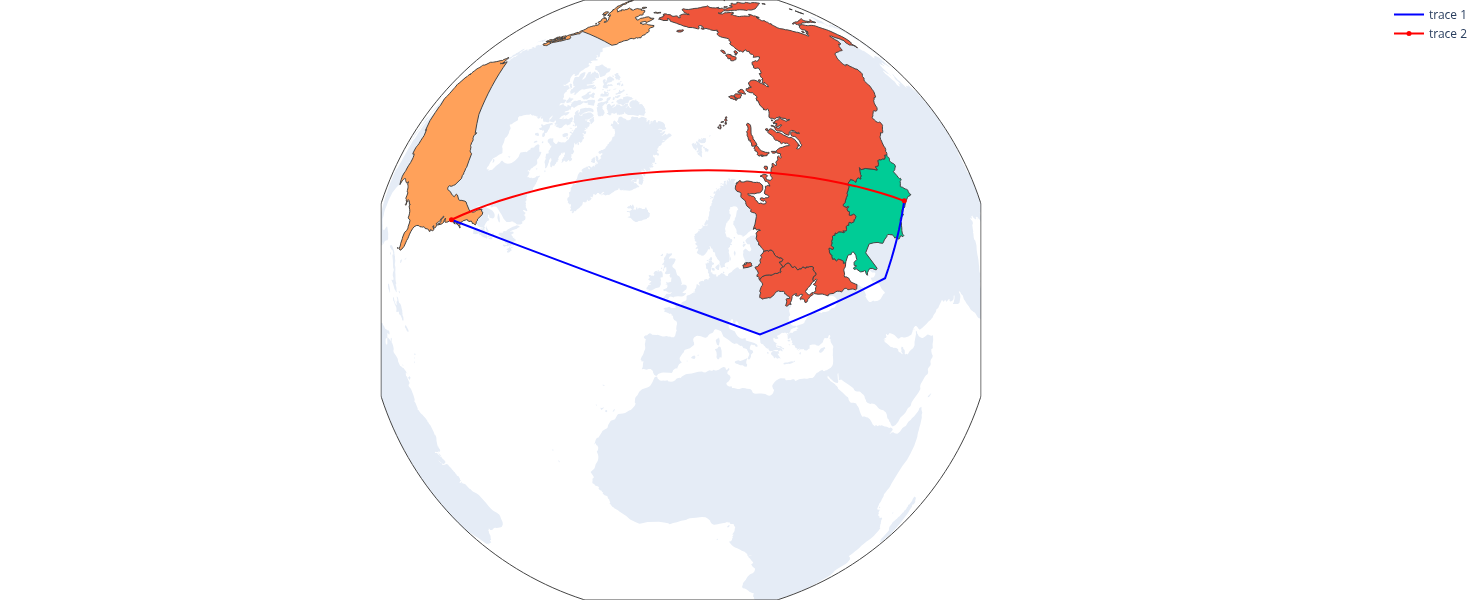

In [15]:
countries = ['KAZ', 'UKR', 'RUS', 'BLR', 'USA']

fig = go.Figure()

trace = go.Choropleth(
    locations=countries,
    z=list(range(len(countries))),
    locationmode='ISO-3',
    colorscale=np.array(px.colors.qualitative.Plotly)[[2, 1, 1, 1, 4]],
    text=countries,
    showscale=False,
)
fig.add_trace(trace)

route_trace = go.Scattergeo(
    lon=gdf_route.geometry.x,
    lat=gdf_route.geometry.y,
    mode='lines',
    marker=dict(size=1, color='blue'),
)
fig.add_trace(route_trace)

start_end = go.Scattergeo(
    lon=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.x,
    lat=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.y,
    mode='lines+markers',
    marker=dict(size=5, color='red'),
)
fig.add_trace(start_end)

fig.update_geos(
    fitbounds='locations',
    visible=False,
    projection_type='orthographic',
)
fig.update_layout(
    autosize=False,
    width=900, height=600,
    margin=dict(l=0, r=0, b=0, t=0),
    geo=dict(
        showframe=True,
        showland=True,
    ),
)
fig.show()

In [37]:
nx.config.backend_priority = ['cugraph']

In [50]:
G.__networkx_cache__.clear()

paths = nx.single_source_dijkstra(
    G, start,
)

In [64]:
points_withtin_range = [
    key
    for key, value
    in paths[0].items()
    if (value * ureg.meter).to(ureg.nautical_mile).magnitude < 7e3
]

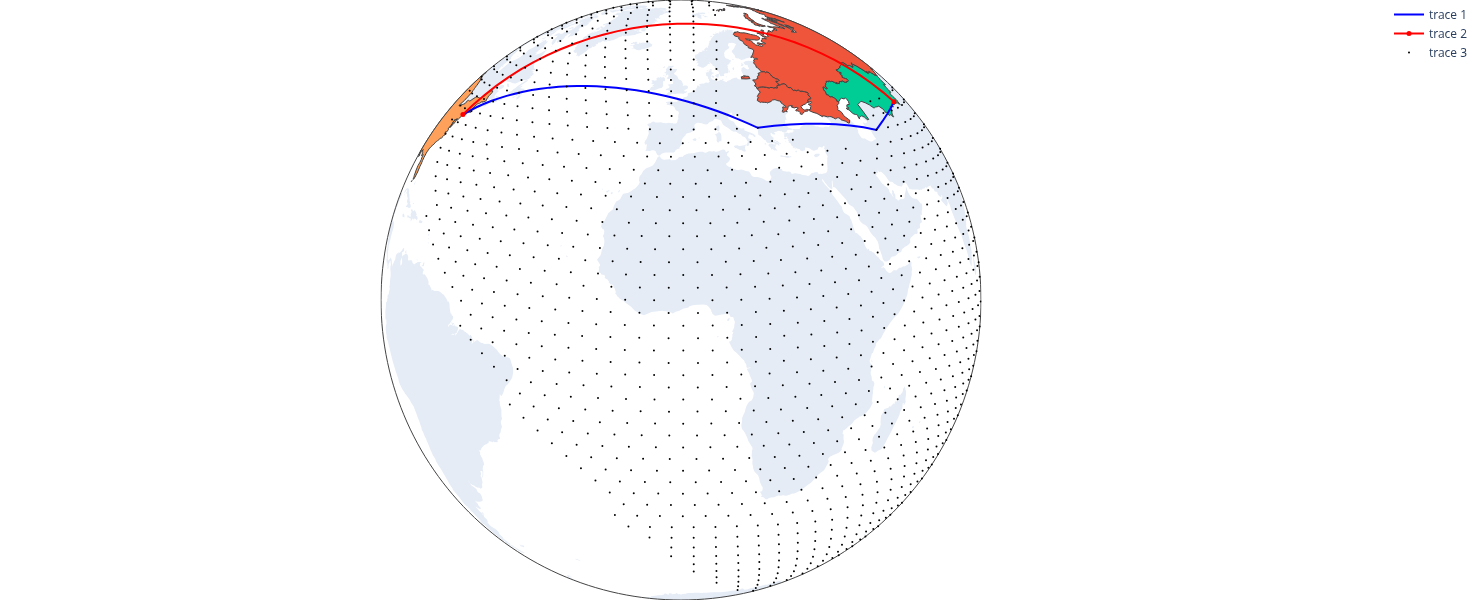

In [115]:
countries = ['KAZ', 'UKR', 'RUS', 'BLR', 'USA']

fig = go.Figure()

trace = go.Choropleth(
    locations=countries,
    z=list(range(len(countries))),
    locationmode='ISO-3',
    colorscale=np.array(px.colors.qualitative.Plotly)[[2, 1, 1, 1, 4]],
    text=countries,
    showscale=False,
)
fig.add_trace(trace)

route_trace = go.Scattergeo(
    lon=gdf_route.geometry.x,
    lat=gdf_route.geometry.y,
    mode='lines',
    marker=dict(size=1, color='blue'),
)
fig.add_trace(route_trace)

start_end = go.Scattergeo(
    lon=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.x,
    lat=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.y,
    mode='lines+markers',
    marker=dict(size=5, color='red'),
)
fig.add_trace(start_end)

points = go.Scattergeo(
    lon=gdf.loc[points_withtin_range].geometry.x,
    lat=gdf.loc[points_withtin_range].geometry.y,
    mode='markers',
    marker=dict(size=2, color='black'),
)
fig.add_trace(points)

fig.update_geos(
    fitbounds='locations',
    visible=False,
    projection_type='orthographic',
)
fig.update_layout(
    autosize=False,
    width=900, height=600,
    margin=dict(l=0, r=0, b=0, t=0),
    geo=dict(
        showframe=True,
        showland=True,
    ),
)
fig.show()

In [138]:
edge_points_mask = np.isin(
    hp.get_all_neighbours(NSIDE, points_withtin_range, nest=True).T,
    points_withtin_range
).sum(axis=1)<7

edge_points = np.array(points_withtin_range)[edge_points_mask]
gdf.loc[edge_points]

,x,y,z,geometry
55,0.533267,0.649787,0.541667,POINT (50.625 32.91413)
60,0.594389,0.594389,0.541667,POINT (45 32.91413)
62,0.601825,0.545462,0.583333,POINT (42.1875 35.80701)
86,0.109366,0.737289,0.666667,POINT (81.5625 41.93785)
87,0.037011,0.706213,0.707031,POINT (87 45.12218)
...,...,...,...,...
372,-0.615593,0.112812,0.779948,POINT (169.61538 51.38099)
375,-0.537405,0.038436,0.842448,POINT (175.90909 57.51586)
365,-0.584034,0.322784,0.744792,POINT (151.07143 48.2687)
364,-0.593093,0.385159,0.707031,POINT (147 45.12218)


In [188]:
edge_points_neighbours = hp.get_all_neighbours(NSIDE, edge_points, nest=True).T

In [215]:
neighbours_drop = edge_points[
    np.unique_counts(
        edge_points_neighbours[
            np.isin(edge_points_neighbours, edge_points)
        ]
    ).counts>2
]

In [ ]:
np.

In [218]:
neighbours_drop

array([427, 628, 808, 810, 905, 907])

In [217]:
{
    point: neighbour_ids[
        np.isin(neighbour_ids, edge_points)
        & ~np.isin(neighbour_ids, neighbours_drop)
    ]
    for point, neighbour_ids
    in zip(edge_points, edge_points_neighbours)
}

{np.int64(55): array([60, 98]),
 np.int64(60): array([62, 55]),
 np.int64(62): array([145,  60]),
 np.int64(86): array([89, 87]),
 np.int64(87): array([86]),
 np.int64(89): array([90, 86]),
 np.int64(90): array([112,  89]),
 np.int64(98): array([55, 99]),
 np.int64(99): array([ 98, 102]),
 np.int64(102): array([ 99, 103]),
 np.int64(103): array([102, 112]),
 np.int64(112): array([103,  90]),
 np.int64(143): array([165, 152]),
 np.int64(145): array([146,  62]),
 np.int64(146): array([152, 145]),
 np.int64(152): array([143, 146]),
 np.int64(165): array([167, 143]),
 np.int64(167): array([184, 165]),
 np.int64(184): array([185, 167]),
 np.int64(185): array([184, 188]),
 np.int64(317): array([318, 360]),
 np.int64(318): array([404, 317]),
 np.int64(360): array([317, 361]),
 np.int64(404): array([406, 318]),
 np.int64(406): array([409, 412, 404]),
 np.int64(409): array([410, 412, 406]),
 np.int64(410): array([421, 409]),
 np.int64(412): array([409, 406]),
 np.int64(421): array([422, 423, 41

In [204]:
np.unique_counts(edge_points_neighbours)

UniqueCountsResult(values=array([  51,   52,   53,   54,   55,   57,   58,   59,   60,   61,   62,
         63,   77,   79,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   96,   97,   98,   99,  100,
        101,  102,  103,  104,  105,  108,  109,  112,  113,  114,  115,
        120,  133,  135,  140,  141,  142,  143,  144,  145,  146,  147,
        148,  149,  150,  152,  153,  154,  155,  164,  165,  166,  167,
        172,  173,  175,  176,  178,  179,  182,  183,  184,  185,  186,
        187,  188,  189,  190,  191,  226,  227,  230,  232,  233,  234,
        235,  236,  237,  238,  239,  242,  243,  246,  247,  248,  249,
        250,  251,  252,  253,  254,  255,  310,  311,  313,  315,  316,
        317,  318,  319,  335,  346,  347,  350,  351,  354,  355,  356,
        357,  358,  359,  360,  361,  362,  363,  364,  365,  366,  367,
        368,  369,  370,  371,  372,  373,  374,  375,  376,  378,  380,
        381,  397,  398, 

In [201]:
{
    point: neighbour_ids[
        np.isin(neighbour_ids, edge_points)
    ]
    for point, neighbour_ids
    in zip(edge_points, edge_points_neighbours)
}

{np.int64(55): array([60, 98]),
 np.int64(60): array([62, 55]),
 np.int64(62): array([145,  60]),
 np.int64(86): array([89, 87]),
 np.int64(87): array([ 86, 427]),
 np.int64(89): array([90, 86]),
 np.int64(90): array([112,  89]),
 np.int64(98): array([55, 99]),
 np.int64(99): array([ 98, 102]),
 np.int64(102): array([ 99, 103]),
 np.int64(103): array([102, 112]),
 np.int64(112): array([103,  90]),
 np.int64(143): array([165, 152]),
 np.int64(145): array([146,  62]),
 np.int64(146): array([152, 145]),
 np.int64(152): array([143, 146]),
 np.int64(165): array([167, 143]),
 np.int64(167): array([184, 165]),
 np.int64(184): array([185, 167]),
 np.int64(185): array([184, 188]),
 np.int64(317): array([318, 360]),
 np.int64(318): array([404, 317]),
 np.int64(360): array([317, 361]),
 np.int64(404): array([406, 318]),
 np.int64(406): array([409, 412, 404]),
 np.int64(409): array([410, 412, 406]),
 np.int64(410): array([421, 409]),
 np.int64(412): array([409, 406]),
 np.int64(421): array([422, 4

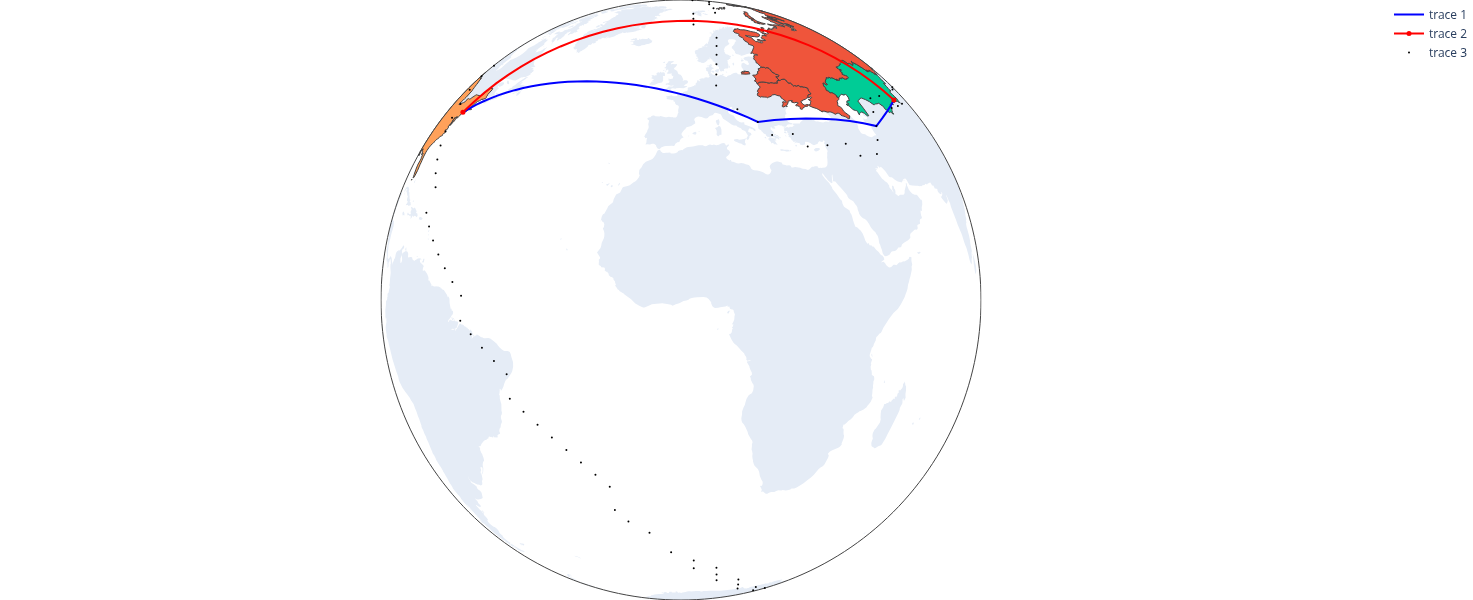

In [139]:
countries = ['KAZ', 'UKR', 'RUS', 'BLR', 'USA']

fig = go.Figure()

trace = go.Choropleth(
    locations=countries,
    z=list(range(len(countries))),
    locationmode='ISO-3',
    colorscale=np.array(px.colors.qualitative.Plotly)[[2, 1, 1, 1, 4]],
    text=countries,
    showscale=False,
)
fig.add_trace(trace)

route_trace = go.Scattergeo(
    lon=gdf_route.geometry.x,
    lat=gdf_route.geometry.y,
    mode='lines',
    marker=dict(size=1, color='blue'),
)
fig.add_trace(route_trace)

start_end = go.Scattergeo(
    lon=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.x,
    lat=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.y,
    mode='lines+markers',
    marker=dict(size=5, color='red'),
)
fig.add_trace(start_end)

points = go.Scattergeo(
    lon=gdf.loc[edge_points].geometry.x,
    lat=gdf.loc[edge_points].geometry.y,
    mode='markers',
    marker=dict(size=2, color='black'),
)
fig.add_trace(points)

fig.update_geos(
    fitbounds='locations',
    visible=False,
    projection_type='orthographic',
)
fig.update_layout(
    autosize=False,
    width=900, height=600,
    margin=dict(l=0, r=0, b=0, t=0),
    geo=dict(
        showframe=True,
        showland=True,
    ),
)
fig.show()

In [ ]:
route_segments = pd.DataFrame([
    {
        'segment': f'{window.point_id.values[0]} - {window.point_id.values[1]}',
        'distance_m': great_circle_distance(*window.geometry.values),
        'distance_nml': (
            great_circle_distance(*window.geometry.values) * ureg.meter
        ).to(ureg.nautical_mile).magnitude,
    }
    for window in gdf_route.rolling(2)
    if len(window) == 2
])
route_segments

In [ ]:
print(
    f'direct UAAA-KJFK: {(
        great_circle_distance(
            *gdf_route[
                gdf_route.point_id.isin(['UAAA', 'KJFK'])
            ].geometry.values
        ) * ureg.meter
    ).to(ureg.nautical_mile).magnitude:.2f} nautical miles'
)
print(f'segmented UAAA-KJFK: {route_segments.distance_nml.sum():.2f} nautical miles')